In [ ]:
from notebook_utils import cd_parent
cd_parent()

from rdkit import Chem

from chemicalgof import (
    Reduce2GoF,
    fragSMILES2GoF,
    Sequence2GoF,
    GoF2Mol,
    GoF2fragSMILES,
    encode,
    decode,
)

from chemicalgof.write import CanonicalGoF2fragSMILES

# How can you reduce atom-based molecular graph into fragment-based molecular graph (DiG)

In [29]:
smiles = 'Cc1cc2c(cc1Cc1ccc(C(=O)NC[C@H]3CC[C@H](C(N)=O)CC3)o1)C(C)(C)CCC2(C)C'
mol = Chem.MolFromSmiles(smiles)

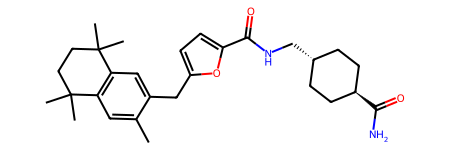

In [30]:
mol

In [31]:
DiG = Reduce2GoF(smiles=smiles)
DiG[DiG.GetFragsByIdx(7)]

AtlasView({C idx:6: {'aB': 0, 'stereo': 'r'}, C=O idx:8: {'aB': 3, 'stereo': 'r'}})

In [32]:
DiG.get_edge_data(DiG.GetFragsByIdx(7), DiG.GetFragsByIdx(8))

{'aB': 3, 'stereo': 'r'}

In [33]:
# or
DiG = Reduce2GoF(mol=mol) # Hint: be sure mol object derives from canonical smiles

In [34]:
DiG.get_edge_data(DiG.GetFragsByIdx(7), DiG.GetFragsByIdx(8))

{'aB': 3, 'stereo': 'r'}

> ⚠️ Example molecule involves pseudochirality (r and s chirality labels), see official [IUPAC notes](https://goldbook.iupac.org/terms/view/P04921).\
> For chemical language model task, chirality can be forced to capital letter

In [35]:
DiG = Reduce2GoF(smiles=smiles, capitalize_legacy=True)
DiG[DiG.GetFragsByIdx(7)]

AtlasView({C idx:6: {'aB': 0, 'stereo': 'R'}, C=O idx:8: {'aB': 3, 'stereo': 'R'}})

# Reduced graph (DiG) can be traversed and encoded into fragSMILES by different ways

In [36]:
smiles = 'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c3ccc(Cl)cc3'
DiG = Reduce2GoF(smiles=smiles)

Graph traversing by canonical way

In [37]:
fragsmiles = GoF2fragSMILES(DiG, canonize=True, random=False)
fragsmiles2 = CanonicalGoF2fragSMILES(DiG)
assert(fragsmiles == fragsmiles2)
fragsmiles

'O.C=O.C.<6>c1ccc2[nH]ccc2c1<4>.<0>(O.C.).<5>(C.).C=O.<0>c1ccccc1<3>.Cl'

In [38]:
DiG.nodes

NodeView((C idx:0, O idx:1, c1ccc2[nH]ccc2c1 idx:2, C idx:3, C=O idx:4, O idx:5, C idx:6, C=O idx:7, c1ccccc1 idx:8, Cl idx:9))

Function `encode` allows to encode SMILES to canonical fragSMILES by one step
> ⚠️pseudo chirality is forced to be capitalized as default. See function documentation

In [39]:
fragsmiles3 = encode(smiles)
assert(fragsmiles == fragsmiles3)

Graph traversing by following node indexes

In [40]:
ordered_fragsmiles = GoF2fragSMILES(DiG, canonize=False, random=False)
print(ordered_fragsmiles)

C.O.<0>c1ccc2[nH]ccc2c1<6>.<4>(C=O.<0>c1ccccc1<3>.Cl.).<5>(C.).C.C=O.O


In [41]:
decoded_DiG = fragSMILES2GoF(fragsmiles)

In [42]:
decoded_DiG.nodes

NodeView((O idx:0, C=O idx:1, C idx:2, c1ccc2[nH]ccc2c1 idx:3, O idx:4, C idx:5, C idx:6, C=O idx:7, c1ccccc1 idx:8, Cl idx:9))

# Reduced graph randomly traversed and augmentation

In [43]:
smiles = 'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c3ccc(Cl)cc3'
DiG = Reduce2GoF(smiles=smiles)

In [44]:
augmented = []
augmentation = 5
max_attempts = 20
attempts = 0
while attempts <= max_attempts and len(augmented) < augmentation:
	decoded = GoF2fragSMILES(DiG, canonize=False, random=True)
	if decoded not in augmented:
		augmented.append(decoded)
		continue
	attempts +=1

In [45]:
augmented

['C.<5>c1ccc2[nH]ccc2c1<0>.<6>(C.C=O.O.).<4>(C=O.<0>c1ccccc1<3>.Cl.).O.C',
 'Cl.<3>c1ccccc1<0>.C=O.<4>c1ccc2[nH]ccc2c1<6>.<0>(O.C.).<5>(C.).C.C=O.O',
 'C.<5>c1ccc2[nH]ccc2c1<4>.<6>(C.C=O.O.).<0>(O.C.).C=O.<0>c1ccccc1<3>.Cl',
 'O.C=O.C.<6>c1ccc2[nH]ccc2c1<5>.<4>(C=O.<0>c1ccccc1<3>.Cl.).<0>(O.C.).C',
 'C.O.<0>c1ccc2[nH]ccc2c1<6>.<4>(C=O.<0>c1ccccc1<3>.Cl.).<5>(C.).C.C=O.O']

# Decoding fragSMILES

List `augmented` of previous section will be employed for decoding phase

In [46]:
decoded_smiles_list = []
for encoded_fragsmiles in augmented:
    decoded_diG = fragSMILES2GoF(encoded_fragsmiles)
    decoded_mol = GoF2Mol(decoded_diG)
    decoded_smiles = Chem.MolToSmiles(decoded_mol)
    decoded_smiles_list.append(Chem.CanonSmiles(decoded_smiles))

In [47]:
# converting into set to remove duplicates
decoded_smiles_set = set(decoded_smiles_list)
decoded_smiles_set

{'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1'}

Function `decode` allows to decode fragSMILES into SMILES by one step

In [48]:
decoded_smiles_list = []
for encoded_fragsmiles in augmented:
    decoded_smiles = decode(encoded_fragsmiles)
    decoded_smiles_list.append(Chem.CanonSmiles(decoded_smiles))

In [49]:
# converting into set to remove duplicates
decoded_smiles_set = set(decoded_smiles_list)
decoded_smiles_set

{'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1'}